In [1]:
from pathlib import Path
import sys
# Agregar el path del directorio "code"
code_path = Path("../code").resolve()
if str(code_path) not in sys.path:
    sys.path.insert(0, str(code_path))

In [2]:
import pandas as pd
import numpy as np
import zipfile
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates
#from utils import get_channel
#from CustomTransformers import TimeSeriesFreqRegularization
#from utils import rolling_forecast
from statsmodels.tsa.arima_process import arma_generate_sample
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from itertools import product
from TimeSeriesUtils import rolling_forecast

In [3]:
df = pd.read_csv("../datasets/electricity.txt", header=None)


In [4]:
df

,0,1,2,3,4,5,6,7,8,9,...,311,312,313,314,315,316,317,318,319,320
0,14.0,69.0,234.0,415.0,215.0,1056.0,29.0,840.0,226.0,265.0,...,676.0,372.0,80100.0,4719.0,5002.0,48.0,38.0,1558.0,182.0,2162.0
1,18.0,92.0,312.0,556.0,292.0,1363.0,29.0,1102.0,271.0,340.0,...,805.0,452.0,95200.0,4643.0,6617.0,65.0,47.0,2177.0,253.0,2835.0
2,21.0,96.0,312.0,560.0,272.0,1240.0,29.0,1025.0,270.0,300.0,...,817.0,430.0,96600.0,4285.0,6571.0,64.0,43.0,2193.0,218.0,2764.0
3,20.0,92.0,312.0,443.0,213.0,845.0,24.0,833.0,179.0,211.0,...,801.0,291.0,94500.0,4222.0,6365.0,65.0,39.0,1315.0,195.0,2735.0
4,22.0,91.0,312.0,346.0,190.0,647.0,16.0,733.0,186.0,179.0,...,807.0,279.0,91300.0,4116.0,6298.0,75.0,40.0,1378.0,191.0,2721.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26299,11.0,116.0,8.0,844.0,384.0,1590.0,51.0,1412.0,407.0,351.0,...,1897.0,1589.0,166500.0,9917.0,10412.0,324.0,21.0,1870.0,162.0,2773.0
26300,11.0,103.0,8.0,749.0,371.0,1366.0,47.0,1265.0,369.0,327.0,...,1374.0,1336.0,158800.0,6812.0,8956.0,302.0,20.0,1506.0,438.0,2755.0
26301,12.0,93.0,8.0,650.0,346.0,1282.0,48.0,1079.0,308.0,283.0,...,938.0,1311.0,154300.0,6602.0,5910.0,302.0,18.0,1864.0,621.0,2650.0
26302,10.0,92.0,8.0,646.0,349.0,1261.0,48.0,1009.0,288.0,292.0,...,833.0,1227.0,141900.0,6546.0,5502.0,259.0,33.0,2623.0,783.0,2719.0


Podemos pensar que la medición es por hora pero realmente "we don’t know when exactly these measurements took place"

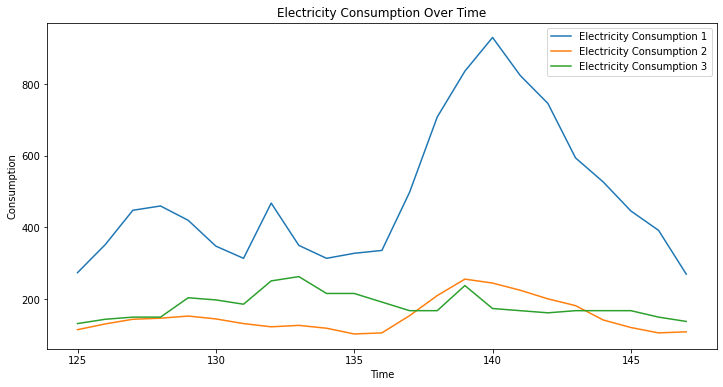

In [5]:
fr = 125
to = 148
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[fr:to, 3], label='Electricity Consumption 1')
plt.plot(df.iloc[fr:to, 13], label='Electricity Consumption 2')
plt.plot(df.iloc[fr:to, 113], label='Electricity Consumption 3')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

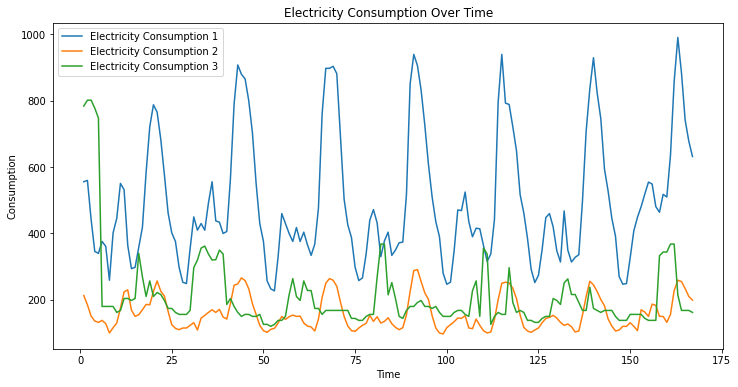

In [27]:
fr = 1
to = 168
plt.figure(figsize=(12, 6))
plt.plot(df.iloc[fr:to, 3], label='Electricity Consumption 1')
plt.plot(df.iloc[fr:to, 13], label='Electricity Consumption 2')
plt.plot(df.iloc[fr:to, 113], label='Electricity Consumption 3')
plt.title('Electricity Consumption Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption')
plt.legend()
plt.show()

Por mas que el aprendizaje profundo tenga mejor tolerancia a series no estacionarias siempre es mejor realizar tareas de ajuste sobre los datos.

window = cuan atrás permitiremos mirar a nuestro modelo, horizon = cuan adelante haremos nuestros pronósticos.